In [2]:
import numpy as np
from itertools import combinations
from copy import deepcopy
import matplotlib.pylab as plt
%matplotlib inline

## Реализация алгоритмов

Реализация алгоритма 1

In [3]:
#принимает на вход массив весов вершин и массив пар ребер
def algorithm_1(weights, edges):
    for (u, v) in edges:
        delta = min(weights[u], weights[v])
        if delta > 0:
            weights[u] -= delta
            weights[v] -= delta
            return algorithm_1(weights, edges)
    return np.arange(len(weights))[weights == 0]
        

Реализация алгоритма 2

In [4]:
#принимает на вход массив весов вершин и матрицу смежности
def algorithm_2(weights, adj_matrix):
    #будем сравнивать не с 0, а с eps, так как при подсчете некоторые знаки после запятой могли потеряться
    eps = 1e-5
    
    #проходимся по вершинам и для вершин с нулевым весом удаляем все инцендентные ей ребра
    for i, w in enumerate(weights):
        if w <= eps:
            weights[i] = 0
            adj_matrix[i, :] = np.zeros_like(adj_matrix[i, :])
            adj_matrix[:, i] = np.zeros_like(adj_matrix[:, i])
    
    #если не осталось ни одного ребра,то завершаем алгоритм и возвращаем вершинное покрытие
    #этим вершинным покрытием будут вершины, получившие вес 0
    if np.sum(adj_matrix) == 0:
        return np.arange(len(weights))[weights == 0]
    
    #иначе находим с такое, что для любой вершины v: w[v] >= c deg[v]
    else:
        c = max(weights)
        for i, w in enumerate(weights):
            deg = sum(adj_matrix[i])
            if w > 0 and deg > 0 and deg * c > 1.0 * w:
                c = 1.0 * w / deg
                
        #изменяем веса
        for i in range(len(weights)):
            deg = sum(adj_matrix[i])
            weights[i] -= c * deg
            
        return algorithm_2(weights, adj_matrix)

## Создание вспомогательных графов

Генерация клики на n вершиных с произвольными весами вершин

In [12]:
def generate_clique(n, seed=0):
    np.random.seed(seed)
    weights = np.random.uniform(0, 1, n)
    adj_matrix = np.ones((n, n)) - np.eye(n)
    edges = [(i, j) for i in range(n) for j in range(i+1, n)]  
    
    return weights, adj_matrix, edges

Генерация дерева на n вершинах с произвольными весами вершин

In [17]:
def generate_tree(n, seed=0):
    np.random.seed(seed)
    weights = np.random.uniform(0, 1, n)
    
    edges = []
    adj_matrix = np.zeros((n, n))
    
    for v in range(1, n):
        #выбираем родителя для вершины v среди первых  v-1 вершин
        parent = np.random.choice(np.arange(v))
        edges.append((parent, v))
        adj_matrix[parent][v] = 1
        adj_matrix[v][parent] = 1
        
    return weights, adj_matrix, edges

## Нахождение оптимального вершинного покрытия для вспомогательных графов

Нахождение веса оптимального вершинного покрытия для клики <br> <br>
Для клики на n вершинах любое вершинное покрытие будет содержать n или n-1 вершину, причем любое множество из n-1 вершины является вершинным покрытием. Поэтому оптимальным вершинным покрытием для клики будут n-1 вершина минимального веса.

In [14]:
def optimal_answer_clique(weights):
    return np.sum(weights) - np.max(weights)

Нахождение веса оптимального вершинного покрытия для дерева. <br> <br>
Алгоритм состоит в следующем: берем вершину v и рассматриваем инциндентные ей ребра (v, u). В оптимальное вершинное покрытие может как попасть, так и не попасть вершина v, поэтому result(V) = min(weight[u] + result(V/{v, u}), weight[v] + result(V / v)). То есть для каждой вершины мы рассматриваем 2 варианта: взять ее или нет. Если мы не берем вершину, то мы обязаны взять инцендентную ей вершину. А если берем, нам нужно выбрать оптимальное вершинное покрытие V/v и объеденить его с v.


In [28]:
def optimal_answer_tree(weights, adj_matrix):
    
    def solve(vertex, parent, need_to_choose, weights, adj_matrix):
        #если кладем вершину vertex в вершинное покрытие
        w1 = weights[vertex]
        for i in range(len(adj_matrix[vertex])):
            if i != parent and adj_matrix[vertex, i] == 1:
                w1 += solve(i, vertex, False, weights, adj_matrix)
                
        #если не кладем вершину vertex в вершинное покрытие
        w2 = 0
        for i in range(len(adj_matrix[vertex])):
            if i != parent and adj_matrix[vertex, i] == 1:
                # должны положить инцендентную вершину в покрытие.
                w2 += solve(i, vertex, True, weights, adj_matrix)
                   
        if need_to_choose:
            return w1
        else:
            return min(w1, w2)
        
    return solve(0, -1, False, weights, adj_matrix)
        

## Проверка на вершинное покрытие

Проверим, являются ли покрытия, полученные первым и вторым алгоритмом, вершинными покрытиями 

In [43]:
def is_vertices_covering(covering, edges):
    covering = set(covering)
    for (u, v) in edges:
        if u not in covering and v not in covering:
            return False
    return True

Проверка для клики

In [61]:
x = range(10, 100, 2)
result1 = []
result2 = []
for n in x:
    weights, adj_matrix, edges = generate_clique(n)
    C = algorithm_1(deepcopy(weights), deepcopy(edges))
    result1.append(is_vertices_covering(C, edges))
    
    C = algorithm_2(deepcopy(weights), deepcopy(adj_matrix))
    result2.append(is_vertices_covering(C, edges))

print('Покрытия, полученные первым алгоритмом, являются вершинными покрытиями? ', np.array(result1).all())
print('Покрытия, полученные вторым алгоритмом, являются вершинными покрытиями? ', np.array(result2).all())

Покрытия, полученные первым алгоритмом, являются вершинными покрытиями?  True
Покрытия, полученные вторым алгоритмом, являются вершинными покрытиями?  True


Проверка для дерева

In [62]:
x = range(10, 100, 2)
result1 = []
result2 = []
for n in x:
    weights, adj_matrix, edges = generate_tree(n)
    C = algorithm_1(deepcopy(weights), deepcopy(edges))
    result1.append(is_vertices_covering(C, edges))
    
    C = algorithm_2(deepcopy(weights), deepcopy(adj_matrix))
    result2.append(is_vertices_covering(C, edges))

print('Покрытия, полученные первым алгоритмом, являются вершинными покрытиями? ', np.array(result1).all())
print('Покрытия, полученные вторым алгоритмом, являются вершинными покрытиями? ', np.array(result2).all())

Покрытия, полученные первым алгоритмом, являются вершинными покрытиями?  True
Покрытия, полученные вторым алгоритмом, являются вершинными покрытиями?  True


## Проверка алгоритмов на 2-приближение

### Проверка для клики

In [53]:
w0 = []
w1 = []
w2 = []
x = range(10, 100, 2)
for n in x:
    weights, adj_matrix, edges = generate_clique(n)
    
    w0.append(optimal_answer_clique(weights))
    
    C = algorithm_1(deepcopy(weights), deepcopy(edges))
    w1.append(sum(weights[C]))
    
    C = algorithm_2(deepcopy(weights), deepcopy(adj_matrix))
    w2.append(sum(weights[C]))

Нарисуем графики зависимости весов, полученных двумя разными алгоритмами, и оптимального веса от n - кол-во вершин клики.

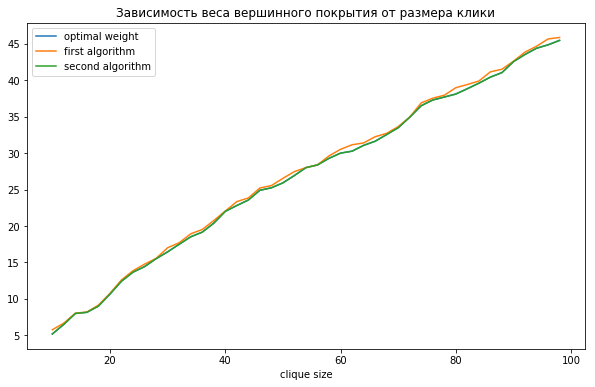

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(x, np.array(w0), label='optimal weight')
plt.plot(x, np.array(w1), label='first algorithm')
plt.plot(x, np.array(w2), label='second algorithm')
plt.xlabel('clique size')
plt.title('Зависимость веса вершинного покрытия от размера клики')
plt.legend(loc='best')
plt.show()

Для более понятной картины, нарисуем зависимость веса вершинного покрытия, деленного на оптимальный вес, от размера клики

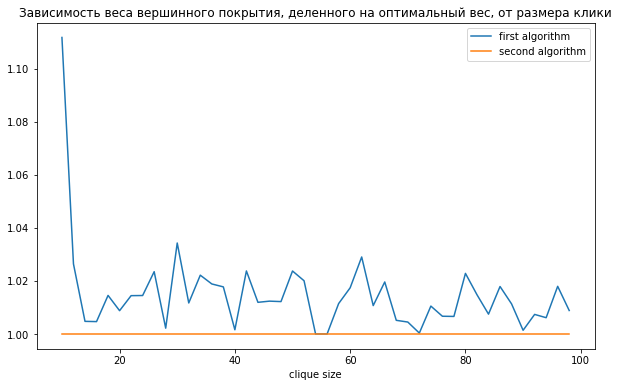

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(x, np.array(w1) / np.array(w0), label='first algorithm')
plt.plot(x, np.array(w2) / np.array(w0), label='second algorithm')
plt.xlabel('clique size')
plt.title('Зависимость веса вершинного покрытия, деленного на оптимальный вес, от размера клики')
plt.legend(loc='best')
plt.show()

### Проверка для дерева.

In [58]:
w0 = []
w1 = []
w2 = []
x = range(10, 100, 2)
for n in x:
    weights, adj_matrix, edges = generate_tree(n)
    
    w0.append(optimal_answer_tree(weights, adj_matrix))
    
    C = algorithm_1(deepcopy(weights), deepcopy(edges))
    w1.append(sum(weights[C]))
    
    C = algorithm_2(deepcopy(weights), deepcopy(adj_matrix))
    w2.append(sum(weights[C]))

Нарисуем графики зависимости весов, полученных двумя разными алгоритмами, и оптимального веса от n - кол-во вершин дерева.


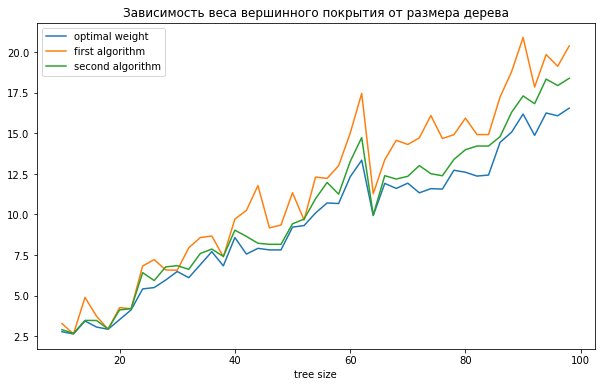

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(x, np.array(w0), label='optimal weight')
plt.plot(x, np.array(w1), label='first algorithm')
plt.plot(x, np.array(w2), label='second algorithm')
plt.xlabel('tree size')
plt.title('Зависимость веса вершинного покрытия от размера дерева')
plt.legend(loc='best')
plt.show()

Для более понятной картины, нарисуем зависимость веса вершинного покрытия, деленного на оптимальный вес, от размера дерева

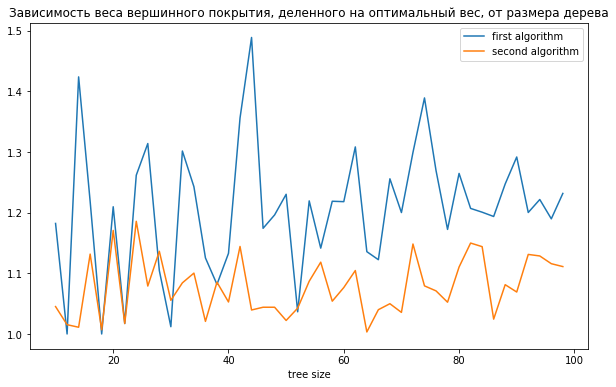

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(x, np.array(w1) / np.array(w0), label='first algorithm')
plt.plot(x, np.array(w2) / np.array(w0), label='second algorithm')
plt.xlabel('tree size')
plt.title('Зависимость веса вершинного покрытия, деленного на оптимальный вес, от размера дерева')
plt.legend(loc='best')
plt.show()